In [7]:
import pandas as pd 
import matplotlib.pyplot as plt
import datetime as dt 
import seaborn as sns
import osmnx as ox
from collections import defaultdict
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import folium
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen

In [8]:
df_05 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202205-divvy-tripdata.csv')
df_06 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202206-divvy-tripdata.csv')
df_07 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202207-divvy-tripdata.csv')
df_08 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202208-divvy-tripdata.csv')
df_09 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202209-divvy-publictripdata.csv')
df_10 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202210-divvy-tripdata.csv')
df_11 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202211-divvy-tripdata.csv')
df_12 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202212-divvy-tripdata.csv')
df_01 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202301-divvy-tripdata.csv')
df_02 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202302-divvy-tripdata.csv')
df_03 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202303-divvy-tripdata.csv')
df_04 = pd.read_csv('/Users/mariu/Desktop/Masterarbeit/archive/202304-divvy-tripdata.csv')

df = pd.concat([df_05, df_06, df_07, df_08, df_09, df_10, df_11, df_12, df_01, df_02, df_03, df_04], ignore_index=True)
df = df.dropna().reset_index()

unique_stations_start = df.groupby('start_station_id').first().reset_index()

# Aggregieren der eindeutigen Endstationen
unique_stations_end = df.groupby('end_station_id').first().reset_index()

# Umbenennen der Spalten, um sie zu vereinheitlichen
unique_stations_start = unique_stations_start.rename(columns={'start_station_id': 'station_id'})
unique_stations_end = unique_stations_end.rename(columns={'end_station_id': 'station_id'})

# Zusammenführen der DataFrames, um eine Liste aller eindeutigen Stationen zu erhalten
unique_stations_master = pd.concat([unique_stations_start[['station_id']], unique_stations_end[['station_id']]]).drop_duplicates().reset_index(drop=True)

df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])


df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60


df = df[(df['ride_duration'] >= 5) & (df['ride_duration'] <= 120)]

df_start = df

In [9]:
# Berechnung der Gesamttrips je Startstation
total_trips_per_start_station = df.groupby('start_station_id')['ride_id'].count().reset_index(name='total_trips_start')

# Filtern der Startstationen mit weniger als 200 Trips
stations_to_remove_start = total_trips_per_start_station[total_trips_per_start_station['total_trips_start'] < 200]['start_station_id']

# Berechnung der Gesamttrips je Endstation
total_trips_per_end_station = df.groupby('end_station_id')['ride_id'].count().reset_index(name='total_trips_end')

# Filtern der Endstationen mit weniger als 200 Trips
stations_to_remove_end = total_trips_per_end_station[total_trips_per_end_station['total_trips_end'] < 200]['end_station_id']

# Kombinieren der Listen der zu entfernenden Stationen ohne Duplikate
stations_to_remove_combined = pd.concat([stations_to_remove_start, stations_to_remove_end]).drop_duplicates().reset_index(drop=True)

# Entfernen der Stationen mit weniger als 200 Trips aus dem Haupt-DataFrame
df_filtered_combined = df[~df['start_station_id'].isin(stations_to_remove_combined) & ~df['end_station_id'].isin(stations_to_remove_combined)]

# Zusammenführen der Informationen von Start- und Endstationen in einem DataFrame
unique_stations_start = df_filtered_combined.groupby('start_station_id').first().reset_index()[['start_station_id', 'start_lat', 'start_lng']].rename(columns={'start_station_id': 'station_id', 'start_lat': 'lat', 'start_lng': 'lng'})
unique_stations_end = df_filtered_combined.groupby('end_station_id').first().reset_index()[['end_station_id', 'end_lat', 'end_lng']].rename(columns={'end_station_id': 'station_id', 'end_lat': 'lat', 'end_lng': 'lng'})

# Vereinigung der einzigartigen Start- und Endstationen, Duplikate entfernen
unique_stations_combined = pd.concat([unique_stations_start, unique_stations_end]).drop_duplicates().reset_index(drop=True)


In [6]:
df_start = df_filtered_combined
df_end = df_filtered_combined


In [12]:
unique_stations_start = df.groupby('start_station_id').first().reset_index()
unique_stations_end = df.groupby('end_station_id').first().reset_index()

In [16]:
# Assuming 'unique_stations_start' and 'unique_stations_end' DataFrames have been correctly defined as shown,
# let's calculate how many stations are common in both and how many are unique to each DataFrame.

# Extracting station IDs as sets for easy comparison
start_station_ids = set(unique_stations_start['start_station_id'])
end_station_ids = set(unique_stations_end['end_station_id'])

# Finding common stations in both DataFrames
common_stations = start_station_ids.intersection(end_station_ids)

# Finding stations unique to each DataFrame
unique_to_start = start_station_ids.difference(end_station_ids)
unique_to_end = end_station_ids.difference(start_station_ids)

# Counting the number of stations in each category
num_common_stations = len(common_stations)
num_unique_to_start = len(unique_to_start)
num_unique_to_end = len(unique_to_end)

num_common_stations, num_unique_to_start, num_unique_to_end


(1235, 23, 45)

/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_38208/1773383821.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start_specific['start_hour'] = df_start_specific['started_at'].dt.hour
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_38208/1773383821.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_start_specific['start_weekday'] = df_start_specific['started_at'].dt.weekday
/var/folders/y8/j3l3spt14jd5q6r19v3l8_800000gn/T/ipykernel_38208/1773383821.py:11: SettingWithCopyWar

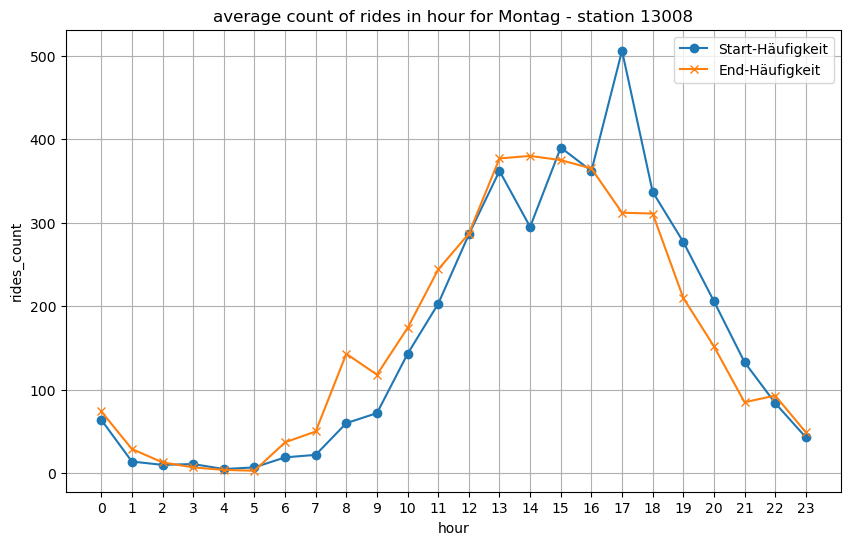

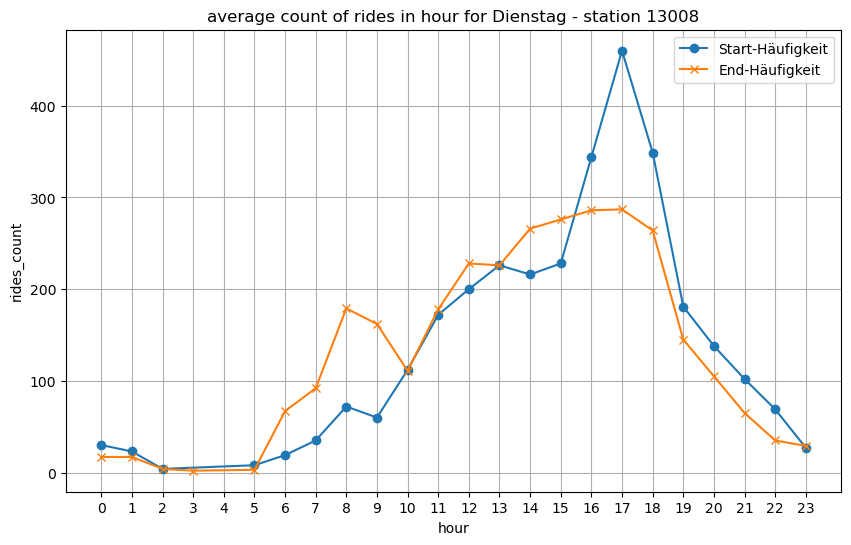

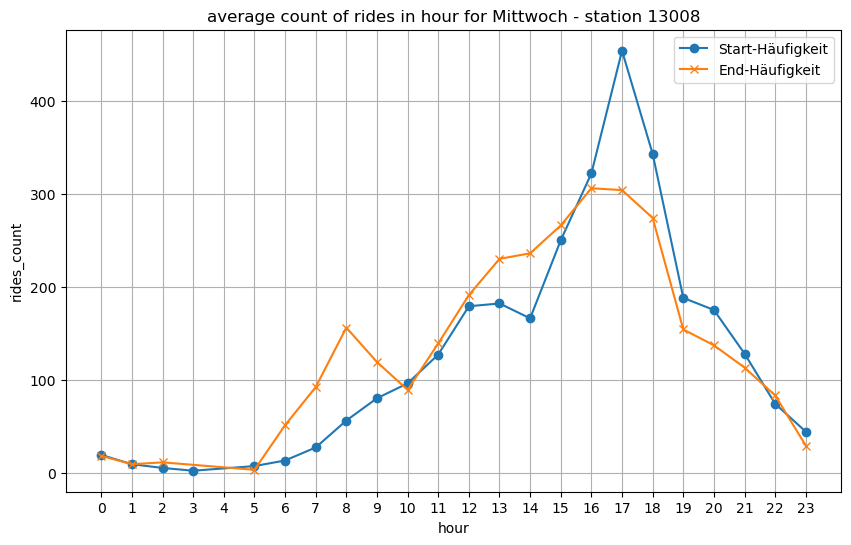

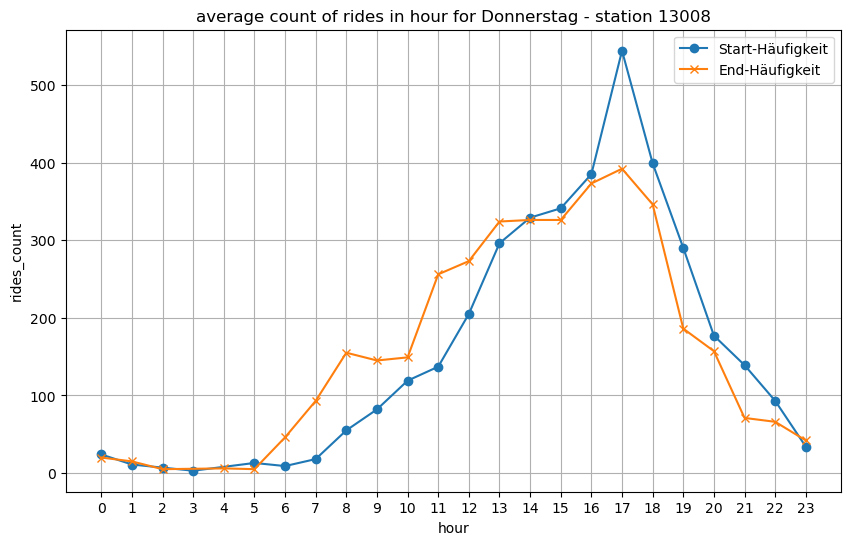

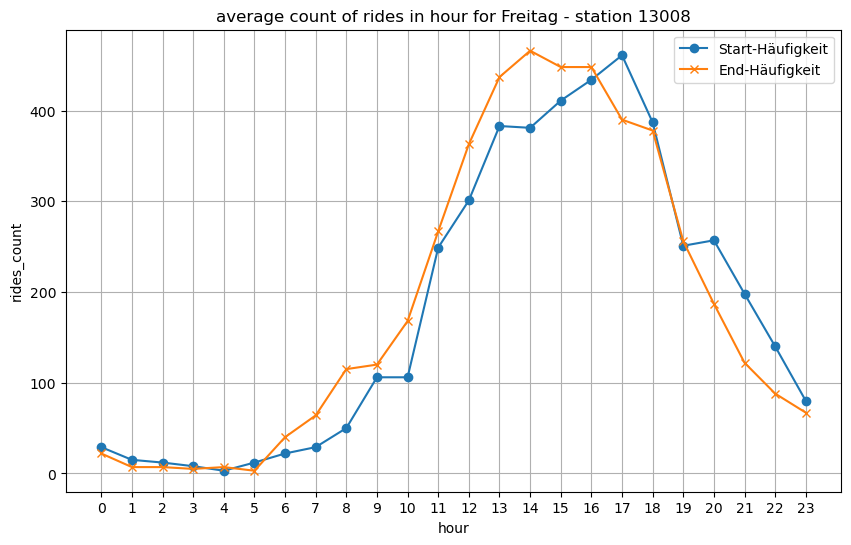

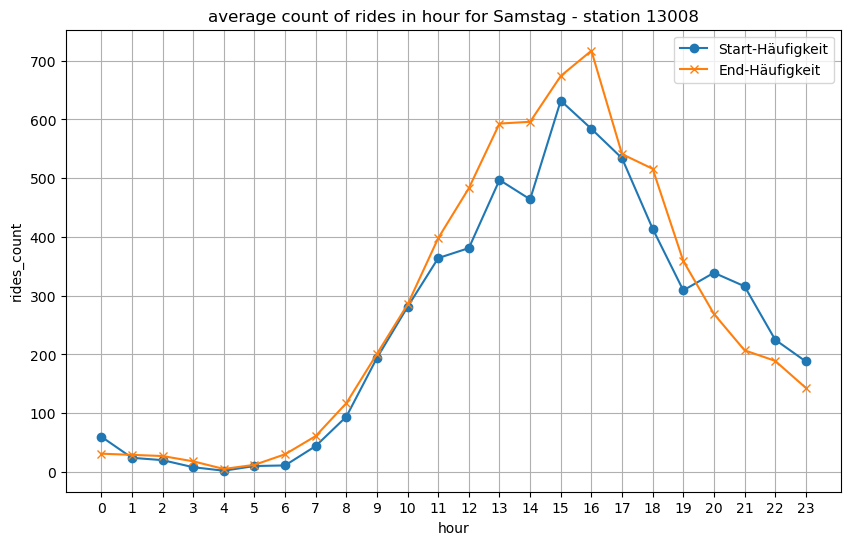

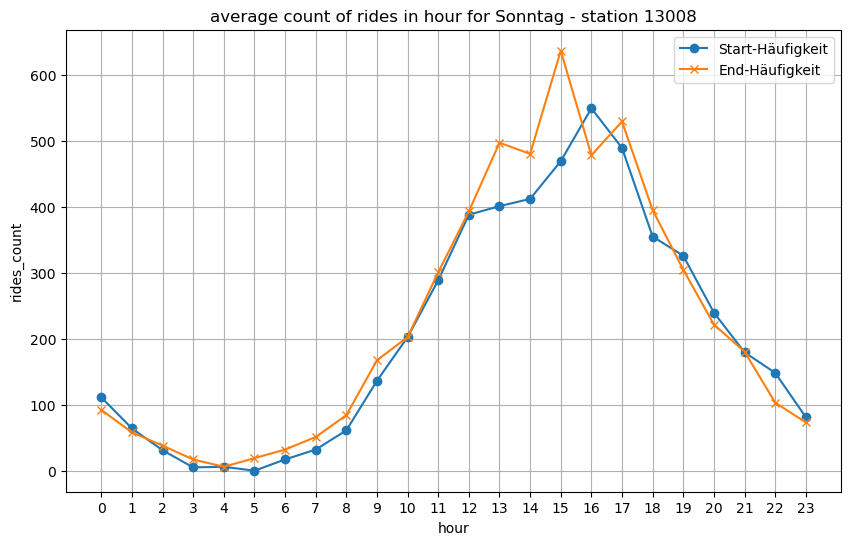

In [10]:
specific_station_id = '13008'

df_start_specific = df[df['start_station_id'] == specific_station_id]

# Filtern der Daten für eine spezifische Station als Endstation
df_end_specific = df[df['end_station_id'] == specific_station_id]

# Extrahieren der Stunden und Wochentage für Start- und Endzeiten
df_start_specific['start_hour'] = df_start_specific['started_at'].dt.hour
df_start_specific['start_weekday'] = df_start_specific['started_at'].dt.weekday
df_end_specific['end_hour'] = df_end_specific['ended_at'].dt.hour
df_end_specific['end_weekday'] = df_end_specific['ended_at'].dt.weekday

# Aggregation der Daten für Start- und Endzeiten
start_agg_specific = df_start_specific.groupby(['start_weekday', 'start_hour']).size().reset_index(name='start_count')
end_agg_specific = df_end_specific.groupby(['end_weekday', 'end_hour']).size().reset_index(name='end_count')

# Namen der Wochentage für die Titel der Schaubilder
weekday_names = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']

# Schaubilder für jeden Wochentag erstellen
for weekday in range(7):
    plt.figure(figsize=(10, 6))
    
    # Filtern der Daten für den spezifischen Wochentag
    start_specific_weekday = start_agg_specific[start_agg_specific['start_weekday'] == weekday]
    end_specific_weekday = end_agg_specific[end_agg_specific['end_weekday'] == weekday]
    
    # Plotten der durchschnittlichen Anzahl der Fahrten je Stunde für Start- und Endzeiten
    plt.plot(start_specific_weekday['start_hour'], start_specific_weekday['start_count'], label='Start-Häufigkeit', marker='o')
    plt.plot(end_specific_weekday['end_hour'], end_specific_weekday['end_count'], label='End-Häufigkeit', marker='x')
    
    plt.title(f'average count of rides in hour for {weekday_names[weekday]} - station {specific_station_id}')
    plt.xlabel('hour')
    plt.ylabel('rides_count')
    plt.xticks(range(0, 24))
    plt.legend()
    plt.grid(True)
    plt.show()

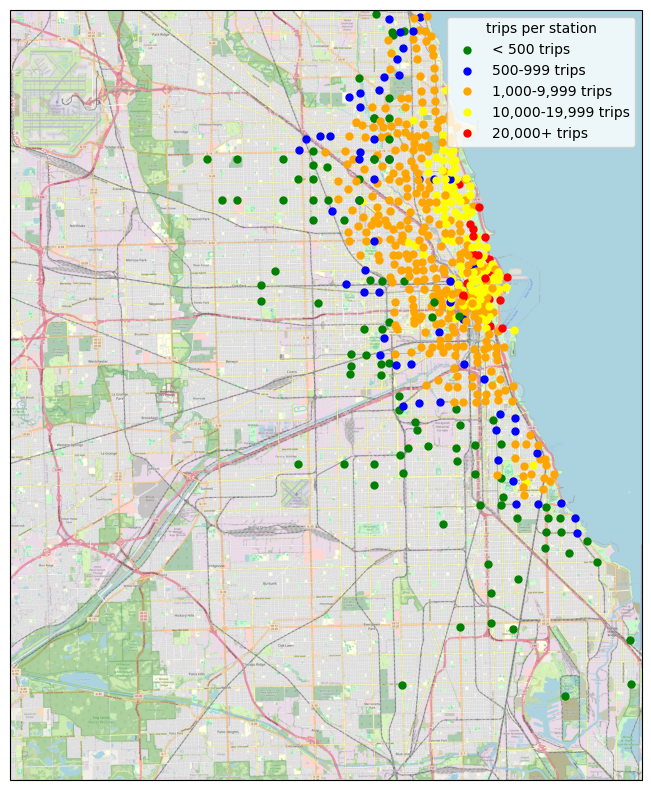

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM


df_start = df_filtered_combined.groupby('start_station_id').agg(
    start_lat=('start_lat', 'mean'),  # Mittlere Position für jede Station
    start_lng=('start_lng', 'mean'),
    start_rides=('ride_id', 'count')  # Anzahl der Fahrten von jeder Startstation
).reset_index()
# Funktion zur Farbgebung basierend auf der Anzahl der Fahrten
def get_color(rides_count):
    if rides_count < 500:
        return 'green'
    elif rides_count < 1000:
        return 'blue'
    elif rides_count < 10000:
        return 'orange'
    elif rides_count < 20000:
        return 'yellow'
    else:
        return 'red'

# Erstellen der Karte
def plot_map(data, title = '' ):
    # OpenStreetMap als Kartenhintergrund
    osm = OSM()
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': osm.crs})  # Breiteres Layout
    # Koordinaten für Chicago, IL
    extent = [-87.9401, -87.5231, 41.6445, 42.0231]  # [west, east, south, north]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Füge den Kartenhintergrund hinzu
    ax.add_image(osm, 13)  # Die Zahl bestimmt die Zoomstufe der Karte

    # Plotte jede Station
    for idx, row in data.iterrows():
        color = get_color(row['start_rides'])
        ax.plot(row['start_lng'], row['start_lat'], 'o', color=color, markersize=5, transform=ccrs.Geodetic())

    # Erstelle eine Legende mit genaueren Intervallen
    ax.legend([plt.Line2D([], [], marker='o', color='green', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='blue', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='orange', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='yellow', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='red', markersize=5, linestyle='')], 
              ['< 500 trips', '500-999 trips', '1,000-9,999 trips', '10,000-19,999 trips', '20,000+ trips'],
              loc='upper right', title="trips per station")
    plt.title(title)
    plt.show()

# Beispiel-Daten (Annahme, dass df_start bereits definiert ist)
data = df_start[['start_lat', 'start_lng', 'start_rides']]

# Rufe die Plot-Funktion auf
plot_map(data)


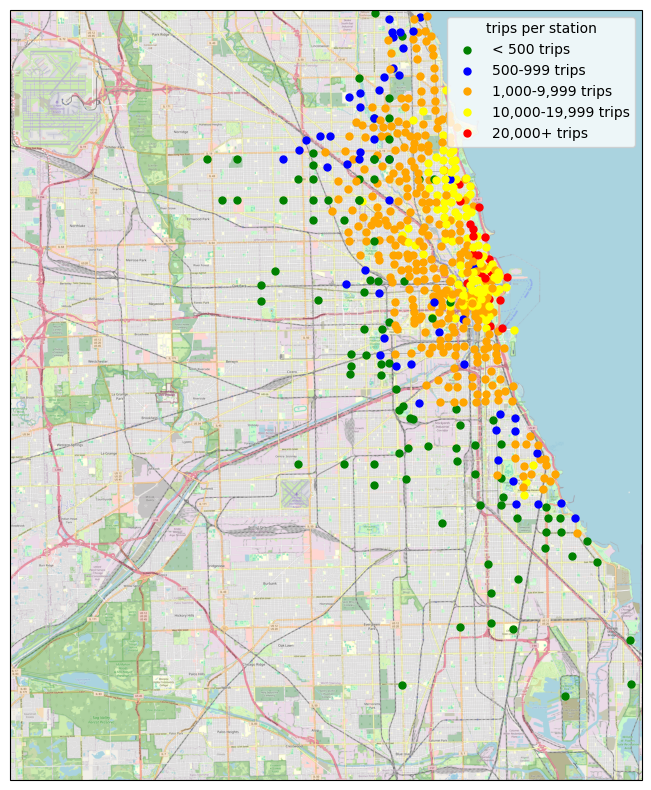

In [12]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
# Berechnung der Gesamtzahl der Fahrten pro Endstation


df_end = df_filtered_combined.groupby('end_station_id').agg(
    end_lat=('end_lat', 'mean'),  # Mittlere Position für jede Station
    end_lng=('end_lng', 'mean'),
    end_rides=('ride_id', 'count')  # Anzahl der Fahrten von jeder Startstation
).reset_index()
# Funktion zur Farbgebung basierend auf der Anzahl der Fahrten
def get_color(rides_count):
    if rides_count < 500:
        return 'green'
    elif rides_count < 1000:
        return 'blue'
    elif rides_count < 10000:
        return 'orange'
    elif rides_count < 20000:
        return 'yellow'
    else:
        return 'red'

# Erstellen der Karte
def plot_map(data, title = '' ):
    # OpenStreetMap als Kartenhintergrund
    osm = OSM()
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': osm.crs})  # Breiteres Layout
    # Koordinaten für Chicago, IL
    extent = [-87.9401, -87.5231, 41.6445, 42.0231]  # [west, east, south, north]
    ax.set_extent(extent, crs=ccrs.PlateCarree())

    # Füge den Kartenhintergrund hinzu
    ax.add_image(osm, 13)  # Die Zahl bestimmt die Zoomstufe der Karte

    # Plotte jede Station
    for idx, row in data.iterrows():
        color = get_color(row['end_rides'])
        ax.plot(row['end_lng'], row['end_lat'], 'o', color=color, markersize=5, transform=ccrs.Geodetic())

    # Erstelle eine Legende mit genaueren Intervallen
    ax.legend([plt.Line2D([], [], marker='o', color='green', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='blue', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='orange', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='yellow', markersize=5, linestyle=''),
               plt.Line2D([], [], marker='o', color='red', markersize=5, linestyle='')], 
              ['< 500 trips', '500-999 trips', '1,000-9,999 trips', '10,000-19,999 trips', '20,000+ trips'],
              loc='upper right', title="trips per station")
    plt.title(title)
    plt.show()

# Beispiel-Daten (Annahme, dass df_start bereits definiert ist)
data = df_end[['end_lat', 'end_lng', 'end_rides']]

# Rufe die Plot-Funktion auf
plot_map(data)


In [10]:
import folium

# Berechnung der Gesamtzahl der Fahrten pro Startstation
df_start = df.groupby('start_station_id').agg(
    start_lat=('start_lat', 'mean'),  # Mittlere Position für jede Station
    start_lng=('start_lng', 'mean'),
    start_rides=('ride_id', 'count')  # Anzahl der Fahrten von jeder Startstation
).reset_index()

# Berechnung der Gesamtzahl der Fahrten pro Endstation
df_end = df.groupby('end_station_id').agg(
    end_lat=('end_lat', 'mean'),  # Mittlere Position für jede Station
    end_lng=('end_lng', 'mean'),
    end_rides=('ride_id', 'count')  # Anzahl der Fahrten zu jeder Endstation
).reset_index()

def get_color(rides_count):
    if rides_count < 500:
        return 'green'
    elif rides_count < 1000:
        return 'blue'
    elif rides_count < 10000:
        return 'orange'
    elif rides_count < 20000:
        return 'yellow'
    else:
        return 'red'

# Erstellen der Karte mit einem mittleren Standort als Ausgangspunkt
map_start = folium.Map(location=[df_start['start_lat'].mean(), df_start['start_lng'].mean()], zoom_start=13)
map_end = folium.Map(location=[df_end['end_lat'].mean(), df_end['end_lng'].mean()], zoom_start=13)

# Hinzufügen der Startstationen zur Karte mit farbigen Kreismarkierungen
for idx, row in df_start.iterrows():
    folium.CircleMarker(
        location=[row['start_lat'], row['start_lng']],
        radius=5,  # Einheitliche Größe für alle Kreise
        color=get_color(row['start_rides']),
        fill=True,
        fill_color=get_color(row['start_rides']),
        fill_opacity=0.7
    ).add_to(map_start)

# Hinzufügen der Endstationen zur Karte mit farbigen Kreismarkierungen
for idx, row in df_end.iterrows():
    folium.CircleMarker(
        location=[row['end_lat'], row['end_lng']],
        radius=5,  # Einheitliche Größe für alle Kreise
        color=get_color(row['end_rides']),
        fill=True,
        fill_color=get_color(row['end_rides']),
        fill_opacity=0.7
    ).add_to(map_end)

# Speichern der Karten als HTML-Dateien
map_start





In [54]:
map_end